In [1]:
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

from models.cnn import ECG1DCNN
from models.mlp import MLP
from utils.data_utils import get_train_test_tensors
from utils.models_utils import MyTrainer
from utils.data_utils import plot_confussion_matrix, plot_loss

# CONSTANTS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(42)
BATCH_SIZE = 64
EXTRA_TRAINER_PARAMS = {
    "optimizer": "Adam",
    "optimizer_kwargs": {"weight_decay": 0.0001},
    "epochs_no": 80,
}

# save_paths stack
save_paths = [
    "figs/Train_Loss_MLP_Patients_adam_decay.png",
    "figs/MLP_Patients_conf_matrix_adam_decay.png",
    "figs/Train_Loss_MLP_ECG_adam_decay.png",
    "figs/MLP_ECG_conf_matrix_adam_decay.png",
    "figs/Train_Loss_CNN_Patients_adam_decay.png",
    "figs/CNN_conf_matrix_adam_decay.png",
]

cuda


In [2]:
df_normal = pd.read_csv("ptbdb_normal.csv", header=None)
df_abnormal = pd.read_csv("ptbdb_abnormal.csv", header=None)

# Split into train, validation, test
df_normal_train = df_normal[: int(0.8 * len(df_normal))]
df_normal_test = df_normal[int(0.8 * len(df_normal)) :]

df_abnormal_train = df_abnormal[: int(0.8 * len(df_abnormal))]
df_abnormal_test = df_abnormal[int(0.8 * len(df_abnormal)) :]

# Add normal and abnormal data together
df_train = pd.concat([df_normal_train, df_abnormal_train])
df_test = pd.concat([df_normal_test, df_abnormal_test])

# Shuffle data
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

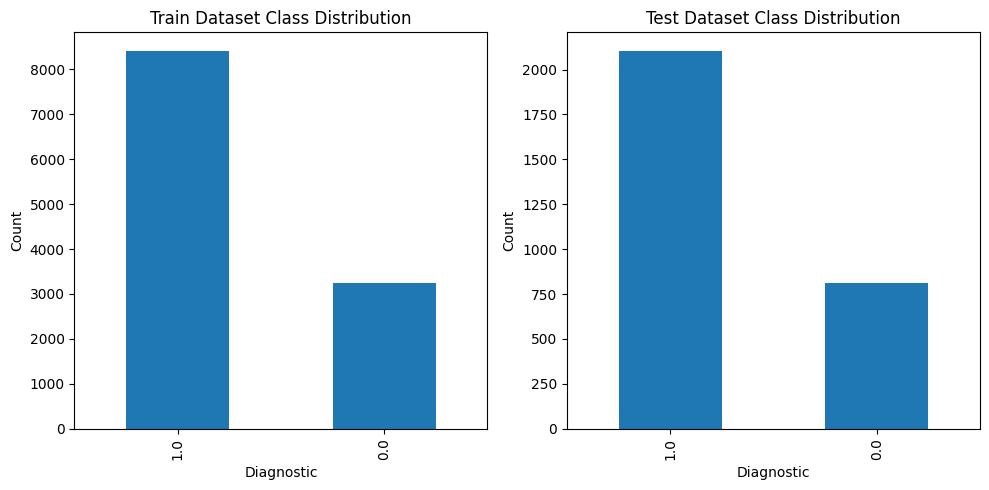

In [3]:
# Analyze class distribution in train and test with barplot
from matplotlib import pyplot as plt


train_class_counts = df_train[187].value_counts()
test_class_counts = df_test[187].value_counts()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
train_class_counts.plot(kind='bar')
plt.xlabel('Diagnostic')
plt.ylabel('Count')
plt.title('Train Dataset Class Distribution')

plt.subplot(1, 2, 2)
test_class_counts.plot(kind='bar')
plt.xlabel('Diagnostic')
plt.ylabel('Count')
plt.title('Test Dataset Class Distribution')

plt.tight_layout()
plt.savefig('figs/train_test_class_distribution.png', dpi=300)
plt.show()

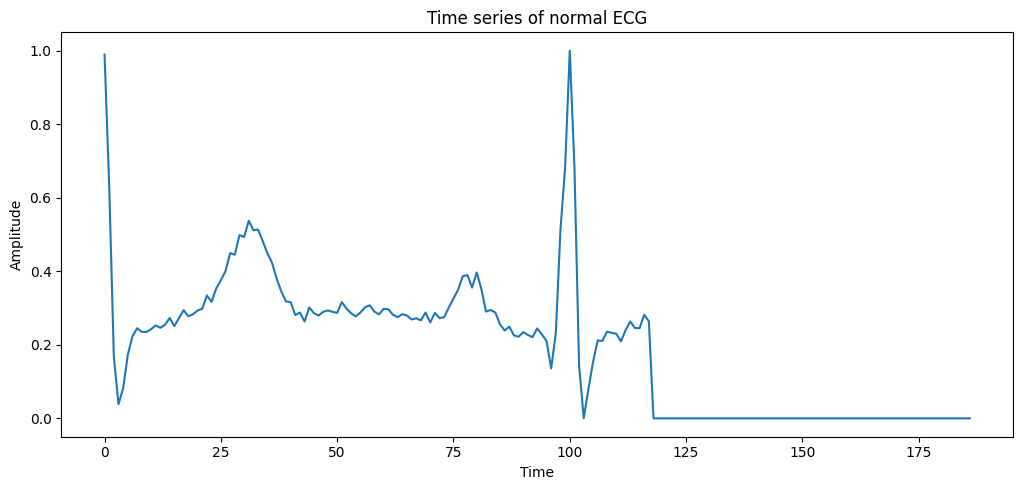

In [4]:
# Display one example of a series for each category of arrhythmia from the PTB dataset.
# x will be the column index, y will be the value of the column on the first row
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(df_train[df_train[187] == 0].iloc[0, :-1])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time series of normal ECG')

plt.tight_layout()
plt.savefig('figs/time_series_normal.png', dpi=300)
plt.show()

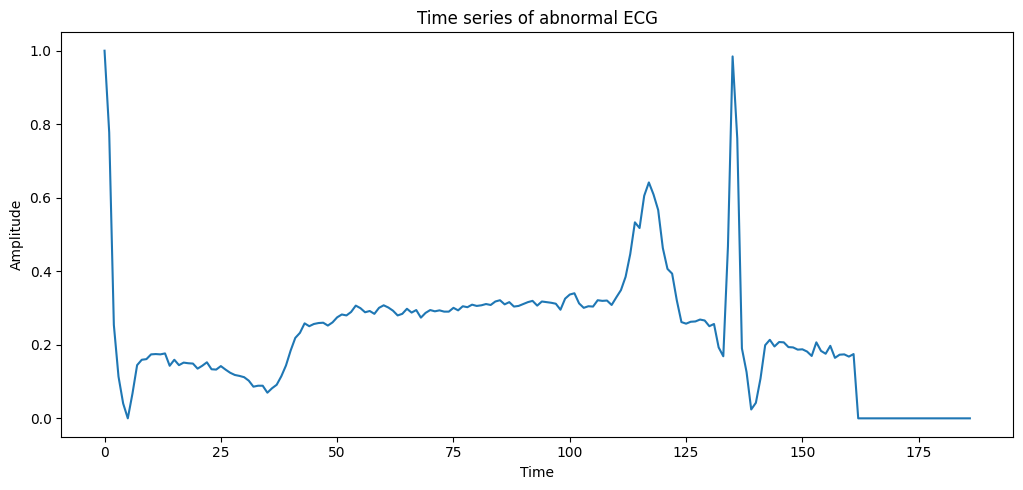

In [5]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(df_train[df_train[187] == 1].iloc[0, :-1])
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time series of abnormal ECG')

plt.tight_layout()
plt.savefig('figs/time_series_abnormal.png', dpi=300)
plt.show()

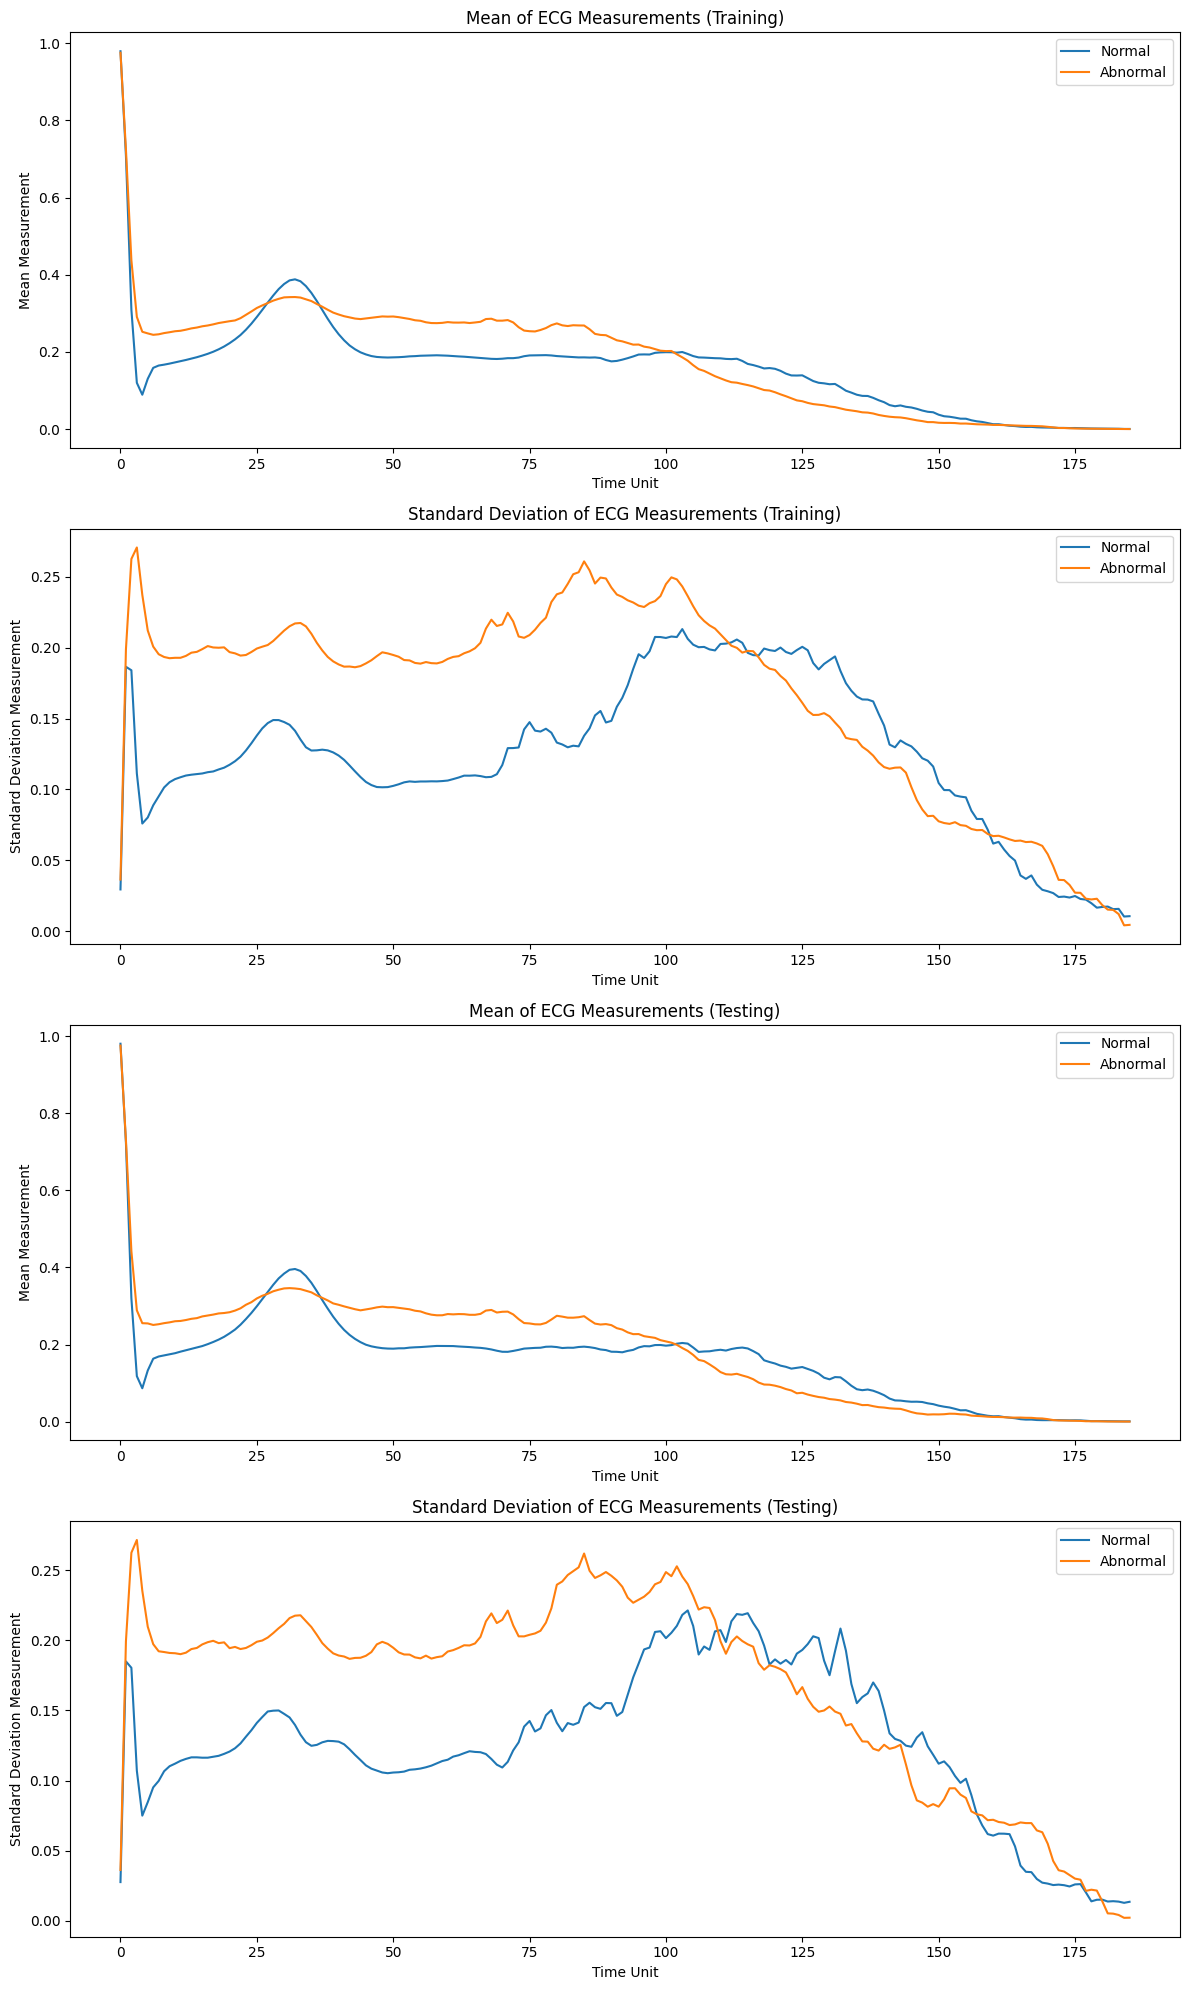

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_train and df_test have been properly prepared and labeled as in your previous code
df_train = df_train.rename(columns={df_train.columns[-1]: 'label'})
df_test = df_test.rename(columns={df_test.columns[-1]: 'label'})

# Calculate mean and standard deviation for each subset and class
grouped_train = df_train.groupby('label')
means_train = grouped_train.apply(lambda x: np.mean(x.iloc[:, :-1], axis=0), include_groups=False)  # Exclude label column for calculations
stds_train = grouped_train.apply(lambda x: np.std(x.iloc[:, :-1], axis=0), include_groups=False)  # Exclude label column for calculations

grouped_test = df_test.groupby('label')
means_test = grouped_test.apply(lambda x: np.mean(x.iloc[:, :-1], axis=0), include_groups=False)  # Exclude label column for calculations
stds_test = grouped_test.apply(lambda x: np.std(x.iloc[:, :-1], axis=0), include_groups=False)  # Exclude label column for calculations

# Plotting
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 20))

# Training Mean Plot
axes[0].plot(means_train.T, label=['Normal', 'Abnormal'])
axes[0].set_title('Mean of ECG Measurements (Training)')
axes[0].set_xlabel('Time Unit')
axes[0].set_ylabel('Mean Measurement')
axes[0].legend()

# Training Standard Deviation Plot
axes[1].plot(stds_train.T, label=['Normal', 'Abnormal'])
axes[1].set_title('Standard Deviation of ECG Measurements (Training)')
axes[1].set_xlabel('Time Unit')
axes[1].set_ylabel('Standard Deviation Measurement')
axes[1].legend()

# Testing Mean Plot
axes[2].plot(means_test.T, label=['Normal', 'Abnormal'])
axes[2].set_title('Mean of ECG Measurements (Testing)')
axes[2].set_xlabel('Time Unit')
axes[2].set_ylabel('Mean Measurement')
axes[2].legend()

# Testing Standard Deviation Plot
axes[3].plot(stds_test.T, label=['Normal', 'Abnormal'])
axes[3].set_title('Standard Deviation of ECG Measurements (Testing)')
axes[3].set_xlabel('Time Unit')
axes[3].set_ylabel('Standard Deviation Measurement')
axes[3].legend()

plt.tight_layout()
plt.savefig('figs/mean_std.png', dpi=300)
plt.show()
